In [1]:
import pandas as pd
import numpy as np 
# import plotly
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.probability import FreqDist
from os import path 
from PIL import Image 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import matplotlib.pyplot as plt 
%matplotlib inline


In [2]:
'''
Issues: 
1. case number = permit number. What is the point of keeping both of them.
2. what is prop_use and existing_use? It is different in API and CSV file
3. last three columns are 2010 Census Neighborhoods, 2010 Census Wards Precincts, and Zipcode, which are different from the API calling
4. what is the point of keeping column 'property_address'
5. Is there a list of work type as a reference? 
'''
# permit_data = 'https://data.baltimorecity.gov/resource/fesm-tgxf.csv'
# house_permit_api = pd.read_csv(permit_data,dtype = 'unicode')

"\nIssues: \n1. case number = permit number. What is the point of keeping both of them.\n2. what is prop_use and existing_use? It is different in API and CSV file\n3. last three columns are 2010 Census Neighborhoods, 2010 Census Wards Precincts, and Zipcode, which are different from the API calling\n4. what is the point of keeping column 'property_address'\n5. Is there a list of work type as a reference? \n"

# Data Cleaning

In [3]:
# Get the price data
house_price_raw = pd.read_excel('RealProp_4_28_20.xlsx')

In [5]:
house_price_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238424 entries, 0 to 238423
Data columns (total 80 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   OBJECTID       238424 non-null  int64  
 1   PIN            238424 non-null  object 
 2   PINRELATE      238424 non-null  object 
 3   BLOCKLOT       238424 non-null  object 
 4   BLOCK          238424 non-null  object 
 5   LOT            238424 non-null  object 
 6   WARD           238424 non-null  int64  
 7   SECTION        238424 non-null  int64  
 8   ASSESSOR       238424 non-null  object 
 9   TAXBASE        238424 non-null  int64  
 10  BFCVLAND       132111 non-null  float64
 11  BFCVIMPR       238424 non-null  int64  
 12  LANDEXMP       238424 non-null  int64  
 13  IMPREXMP       238424 non-null  int64  
 14  CITYCRED       234220 non-null  float64
 15  STATCRED       238424 non-null  float64
 16  CCREDAMT       238424 non-null  float64
 17  SCREDAMT       238181 non-nul

In [33]:
house_price_filter = house_price_raw.filter(items = ['PIN','BLOCK','LOT','TAXBASE','FULLCASH'])
house_price_filter['VALUE'] = house_price_filter['TAXBASE'] + house_price_filter['FULLCASH']
house_price_filter.head(100)

,PIN,BLOCK,LOT,TAXBASE,FULLCASH,VALUE
0,0001001,0001,001,141800,0,141800
1,0001002,0001,002,49500,0,49500
2,0001003,0001,003,7000,0,7000
3,0001004,0001,004,7000,0,7000
4,0001005,0001,005,21667,0,21667
...,...,...,...,...,...,...
95,0002043,0002,043,5333,0,5333
96,0002044,0002,044,6000,0,6000
97,0002045,0002,045,5333,0,5333
98,0002046,0002,046,36667,0,36667


In [11]:
house_permit_from_file = pd.read_csv('Housing_Permits.csv',dtype = 'unicode')
house_permit_from_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634950 entries, 0 to 634949
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   PermitID                     634950 non-null  object
 1   CaseNum                      634950 non-null  object
 2   Block                        634947 non-null  object
 3   Lot                          634947 non-null  object
 4   PropertyAddress              634882 non-null  object
 5   PermitNum                    634950 non-null  object
 6   DateIssue                    634950 non-null  object
 7   PermitDescription            615005 non-null  object
 8   Cost_Est                     468980 non-null  object
 9   DateExpire                   577165 non-null  object
 10  Prop_Use                     582264 non-null  object
 11  Existing_Use                 582436 non-null  object
 12  Neighborhood                 611060 non-null  object
 13  PoliceDistrict

In [12]:
# Question 1 What types of construction permits are people pulling?

house_permit_from_file['PermitDescription'] = house_permit_from_file['PermitDescription'].astype(str)
house_permit_from_file['Location'] = house_permit_from_file['Location'].astype(str)
house_permit_from_file = house_permit_from_file[house_permit_from_file['PermitDescription'].notnull()]


In [13]:
house_permit_from_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634950 entries, 0 to 634949
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   PermitID                     634950 non-null  object
 1   CaseNum                      634950 non-null  object
 2   Block                        634947 non-null  object
 3   Lot                          634947 non-null  object
 4   PropertyAddress              634882 non-null  object
 5   PermitNum                    634950 non-null  object
 6   DateIssue                    634950 non-null  object
 7   PermitDescription            634950 non-null  object
 8   Cost_Est                     468980 non-null  object
 9   DateExpire                   577165 non-null  object
 10  Prop_Use                     582264 non-null  object
 11  Existing_Use                 582436 non-null  object
 12  Neighborhood                 611060 non-null  object
 13  PoliceDistrict

In [14]:
house_permit_from_file['Block'] = house_permit_from_file['Block'].str.zfill(4)
house_permit_from_file['Lot'] = house_permit_from_file['Lot'].str.zfill(3)
house_permit_from_file['PIN'] = house_permit_from_file['Block'] + house_permit_from_file['Lot']
house_permit_from_file.head()

,PermitID,CaseNum,Block,Lot,PropertyAddress,PermitNum,DateIssue,PermitDescription,Cost_Est,DateExpire,Prop_Use,Existing_Use,Neighborhood,PoliceDistrict,CouncilDistrict,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes,PIN
0,20151202163056763B,COM2015-28907,1451,014,1752 N GAY ST,COM2015-28907,03/28/2019,interior and exterior alteration of an existin...,700000.00,03/28/2021,ASM,ASM,BROADWAY EAST,Eastern,12,"1752 N GAY ST\nBaltimore, MD\n(39.310536, -76....",23,148,26956,1451014
1,20180215133007957B,DEM2018-50023,4250,041,3401 LABYRINTH RD,DEM2018-50023,03/28/2019,demolition of building/structure(wood)(1) leng...,0.00,09/28/2019,NaN,1-05,CROSS COUNTRY,Northwestern,5,"3401 LABYRINTH RD\nBaltimore, MD\n(39.3669, -7...",58,276,27295,4250041
2,200805211220025130,COM2008-14406,3463F,005B,815 BROOKS LANE,COM2008-14406,06/05/2008,new windows (13) 2-new exterior doors ceramic...,12000.00,12/05/2008,SF,VAC,RESERVOIR HILL,Central,7,"815 BROOKS LANE\nBaltimore, MD\n(39.315946, -7...",210,17,27301,3463F005B
3,20191219115630173B,COM2019-88415,1732,042,3126 E BALTIMORE ST,COM2019-88415,12/26/2019,scope of work: interior alterations to include...,15000.00,06/26/2020,1-05,1-05,BALTIMORE-LINWOOD,Southeastern,1,"3126 E BALTIMORE ST\nBaltimore, MD\n(39.292363...",9,118,27935,1732042
4,20191226094441660W,COM2019-88825,0503,012,222 W READ ST,COM2019-88825,12/26/2019,amend to add electrical contractor: (original ...,NaN,06/26/2020,3-42,3-42,MID-TOWN BELVEDERE,Central,11,"222 W READ ST\nBaltimore, MD\n(39.30066, -76.6...",165,93,13642,0503012


In [15]:
# Since pandas dataframe would store the address of the string, it would always show strings as object. Remeber to use .str to refer to it 
house_permit_from_file['Location_list'] = house_permit_from_file['Location'].str.split()
house_permit_from_file.head()

,PermitID,CaseNum,Block,Lot,PropertyAddress,PermitNum,DateIssue,PermitDescription,Cost_Est,DateExpire,...,Existing_Use,Neighborhood,PoliceDistrict,CouncilDistrict,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes,PIN,Location_list
0,20151202163056763B,COM2015-28907,1451,014,1752 N GAY ST,COM2015-28907,03/28/2019,interior and exterior alteration of an existin...,700000.00,03/28/2021,...,ASM,BROADWAY EAST,Eastern,12,"1752 N GAY ST\nBaltimore, MD\n(39.310536, -76....",23,148,26956,1451014,"[1752, N, GAY, ST, Baltimore,, MD, (39.310536,..."
1,20180215133007957B,DEM2018-50023,4250,041,3401 LABYRINTH RD,DEM2018-50023,03/28/2019,demolition of building/structure(wood)(1) leng...,0.00,09/28/2019,...,1-05,CROSS COUNTRY,Northwestern,5,"3401 LABYRINTH RD\nBaltimore, MD\n(39.3669, -7...",58,276,27295,4250041,"[3401, LABYRINTH, RD, Baltimore,, MD, (39.3669..."
2,200805211220025130,COM2008-14406,3463F,005B,815 BROOKS LANE,COM2008-14406,06/05/2008,new windows (13) 2-new exterior doors ceramic...,12000.00,12/05/2008,...,VAC,RESERVOIR HILL,Central,7,"815 BROOKS LANE\nBaltimore, MD\n(39.315946, -7...",210,17,27301,3463F005B,"[815, BROOKS, LANE, Baltimore,, MD, (39.315946..."
3,20191219115630173B,COM2019-88415,1732,042,3126 E BALTIMORE ST,COM2019-88415,12/26/2019,scope of work: interior alterations to include...,15000.00,06/26/2020,...,1-05,BALTIMORE-LINWOOD,Southeastern,1,"3126 E BALTIMORE ST\nBaltimore, MD\n(39.292363...",9,118,27935,1732042,"[3126, E, BALTIMORE, ST, Baltimore,, MD, (39.2..."
4,20191226094441660W,COM2019-88825,0503,012,222 W READ ST,COM2019-88825,12/26/2019,amend to add electrical contractor: (original ...,NaN,06/26/2020,...,3-42,MID-TOWN BELVEDERE,Central,11,"222 W READ ST\nBaltimore, MD\n(39.30066, -76.6...",165,93,13642,0503012,"[222, W, READ, ST, Baltimore,, MD, (39.30066,,..."


In [16]:
house_permit_from_file['Length'] = house_permit_from_file['Location_list'].str.len()
house_permit_from_file.head()

,PermitID,CaseNum,Block,Lot,PropertyAddress,PermitNum,DateIssue,PermitDescription,Cost_Est,DateExpire,...,Neighborhood,PoliceDistrict,CouncilDistrict,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes,PIN,Location_list,Length
0,20151202163056763B,COM2015-28907,1451,014,1752 N GAY ST,COM2015-28907,03/28/2019,interior and exterior alteration of an existin...,700000.00,03/28/2021,...,BROADWAY EAST,Eastern,12,"1752 N GAY ST\nBaltimore, MD\n(39.310536, -76....",23,148,26956,1451014,"[1752, N, GAY, ST, Baltimore,, MD, (39.310536,...",8
1,20180215133007957B,DEM2018-50023,4250,041,3401 LABYRINTH RD,DEM2018-50023,03/28/2019,demolition of building/structure(wood)(1) leng...,0.00,09/28/2019,...,CROSS COUNTRY,Northwestern,5,"3401 LABYRINTH RD\nBaltimore, MD\n(39.3669, -7...",58,276,27295,4250041,"[3401, LABYRINTH, RD, Baltimore,, MD, (39.3669...",7
2,200805211220025130,COM2008-14406,3463F,005B,815 BROOKS LANE,COM2008-14406,06/05/2008,new windows (13) 2-new exterior doors ceramic...,12000.00,12/05/2008,...,RESERVOIR HILL,Central,7,"815 BROOKS LANE\nBaltimore, MD\n(39.315946, -7...",210,17,27301,3463F005B,"[815, BROOKS, LANE, Baltimore,, MD, (39.315946...",7
3,20191219115630173B,COM2019-88415,1732,042,3126 E BALTIMORE ST,COM2019-88415,12/26/2019,scope of work: interior alterations to include...,15000.00,06/26/2020,...,BALTIMORE-LINWOOD,Southeastern,1,"3126 E BALTIMORE ST\nBaltimore, MD\n(39.292363...",9,118,27935,1732042,"[3126, E, BALTIMORE, ST, Baltimore,, MD, (39.2...",8
4,20191226094441660W,COM2019-88825,0503,012,222 W READ ST,COM2019-88825,12/26/2019,amend to add electrical contractor: (original ...,NaN,06/26/2020,...,MID-TOWN BELVEDERE,Central,11,"222 W READ ST\nBaltimore, MD\n(39.30066, -76.6...",165,93,13642,0503012,"[222, W, READ, ST, Baltimore,, MD, (39.30066,,...",8


In [17]:
# Get latitude and longitude by spliting the string 
house_permit_from_file['lat'] = house_permit_from_file['Location_list'].str[-2].str.strip('(')
house_permit_from_file['long'] = house_permit_from_file['Location_list'].str[-1].str.strip(')')
house_permit_from_file.head()

,PermitID,CaseNum,Block,Lot,PropertyAddress,PermitNum,DateIssue,PermitDescription,Cost_Est,DateExpire,...,CouncilDistrict,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes,PIN,Location_list,Length,lat,long
0,20151202163056763B,COM2015-28907,1451,014,1752 N GAY ST,COM2015-28907,03/28/2019,interior and exterior alteration of an existin...,700000.00,03/28/2021,...,12,"1752 N GAY ST\nBaltimore, MD\n(39.310536, -76....",23,148,26956,1451014,"[1752, N, GAY, ST, Baltimore,, MD, (39.310536,...",8,"39.310536,",-76.586421
1,20180215133007957B,DEM2018-50023,4250,041,3401 LABYRINTH RD,DEM2018-50023,03/28/2019,demolition of building/structure(wood)(1) leng...,0.00,09/28/2019,...,5,"3401 LABYRINTH RD\nBaltimore, MD\n(39.3669, -7...",58,276,27295,4250041,"[3401, LABYRINTH, RD, Baltimore,, MD, (39.3669...",7,"39.3669,",-76.698112
2,200805211220025130,COM2008-14406,3463F,005B,815 BROOKS LANE,COM2008-14406,06/05/2008,new windows (13) 2-new exterior doors ceramic...,12000.00,12/05/2008,...,7,"815 BROOKS LANE\nBaltimore, MD\n(39.315946, -7...",210,17,27301,3463F005B,"[815, BROOKS, LANE, Baltimore,, MD, (39.315946...",7,"39.315946,",-76.634808
3,20191219115630173B,COM2019-88415,1732,042,3126 E BALTIMORE ST,COM2019-88415,12/26/2019,scope of work: interior alterations to include...,15000.00,06/26/2020,...,1,"3126 E BALTIMORE ST\nBaltimore, MD\n(39.292363...",9,118,27935,1732042,"[3126, E, BALTIMORE, ST, Baltimore,, MD, (39.2...",8,"39.292363,",-76.572507
4,20191226094441660W,COM2019-88825,0503,012,222 W READ ST,COM2019-88825,12/26/2019,amend to add electrical contractor: (original ...,NaN,06/26/2020,...,11,"222 W READ ST\nBaltimore, MD\n(39.30066, -76.6...",165,93,13642,0503012,"[222, W, READ, ST, Baltimore,, MD, (39.30066,,...",8,"39.30066,",-76.619321


(-0.5, 399.5, 199.5, -0.5)

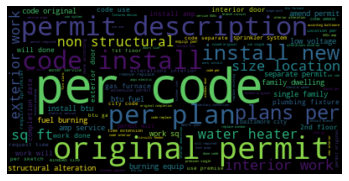

In [10]:
description_list = house_permit_from_file['PermitDescription'].tolist()
description_text = (' '.join(description_list))
wordcloud_description = WordCloud().generate(description_text)
plt.imshow(wordcloud_description, interpolation = 'bilinear')
plt.axis('off')

(-0.5, 999.5, 999.5, -0.5)

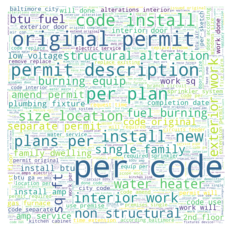

In [14]:
worldcloud_description2 = WordCloud(max_words = 5000,
                                     height = 1000,
                                     width = 1000,
                                     background_color = 'white').generate(description_text)
plt.figure()
plt.imshow(worldcloud_description2, interpolation="bilinear")
plt.axis("off")

In [19]:
house_permit_from_file['lowercase'] = house_permit_from_file['PermitDescription'].str.lower()

In [20]:
# First time, please uncomment the following line and download punkt. But once you have that, you don't have to redownload it again. 
# This would take about 1-3 minutes to download depending on your network
# nltk.download('punkt')
house_permit_from_file['tokenized_text'] = house_permit_from_file['lowercase'].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wzixu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
house_permit_from_file_filter = house_permit_from_file.filter(items = ['PropertyAddress','lat','long','lowercase','PIN','DateIssue','tokenized_text']).reset_index()
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,tokenized_text
0,0,1752 N GAY ST,"39.310536,",-76.586421,interior and exterior alteration of an existin...,1451014,03/28/2019,"[interior, and, exterior, alteration, of, an, ..."
1,1,3401 LABYRINTH RD,"39.3669,",-76.698112,demolition of building/structure(wood)(1) leng...,4250041,03/28/2019,"[demolition, of, building/structure, (, wood, ..."
2,2,815 BROOKS LANE,"39.315946,",-76.634808,new windows (13) 2-new exterior doors ceramic...,3463F005B,06/05/2008,"[new, windows, (, 13, ), 2-new, exterior, door..."
3,3,3126 E BALTIMORE ST,"39.292363,",-76.572507,scope of work: interior alterations to include...,1732042,12/26/2019,"[scope, of, work, :, interior, alterations, to..."
4,4,222 W READ ST,"39.30066,",-76.619321,amend to add electrical contractor: (original ...,0503012,12/26/2019,"[amend, to, add, electrical, contractor, :, (,..."


In [29]:
#nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
house_permit_from_file_filter['no_stopwords'] = house_permit_from_file_filter['tokenized_text'].apply(lambda tokenized_list:[word for word in tokenized_list if word not in stop_words])

In [30]:
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,tokenized_text,no_stopwords
0,0,1752 N GAY ST,"39.310536,",-76.586421,interior and exterior alteration of an existin...,1451014,03/28/2019,"[interior, and, exterior, alteration, of, an, ...","[interior, exterior, alteration, existing, bui..."
1,1,3401 LABYRINTH RD,"39.3669,",-76.698112,demolition of building/structure(wood)(1) leng...,4250041,03/28/2019,"[demolition, of, building/structure, (, wood, ...","[demolition, building/structure, (, wood, ), (..."
2,2,815 BROOKS LANE,"39.315946,",-76.634808,new windows (13) 2-new exterior doors ceramic...,3463F005B,06/05/2008,"[new, windows, (, 13, ), 2-new, exterior, door...","[new, windows, (, 13, ), 2-new, exterior, door..."
3,3,3126 E BALTIMORE ST,"39.292363,",-76.572507,scope of work: interior alterations to include...,1732042,12/26/2019,"[scope, of, work, :, interior, alterations, to...","[scope, work, :, interior, alterations, includ..."
4,4,222 W READ ST,"39.30066,",-76.619321,amend to add electrical contractor: (original ...,0503012,12/26/2019,"[amend, to, add, electrical, contractor, :, (,...","[amend, add, electrical, contractor, :, (, ori..."


In [31]:
# Do the stem of each word
ps = PorterStemmer()

In [32]:
house_permit_from_file_filter['stem_words'] = house_permit_from_file_filter['no_stopwords'].apply(lambda sublist : [ps.stem(word) for word in sublist])

In [34]:
symbol_list = ["!", ")","(", ":", ",",".", "...","-", "|", "'",'"','’','…',"“","”","&","^",";","@","#","$","%","_","+","="]
stop_words.update(symbol_list)
house_permit_from_file_filter['no_symbols'] = house_permit_from_file_filter['stem_words'].apply(lambda x: [word for word in x if word not in stop_words])
house_permit_from_file_filter['no_symbols'] = house_permit_from_file_filter['no_symbols'].apply(lambda x: [word for word in x if not word.isnumeric()])
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,tokenized_text,no_stopwords,stem_words,no_symbols
0,0,1752 N GAY ST,"39.310536,",-76.586421,interior and exterior alteration of an existin...,1451014,03/28/2019,"[interior, and, exterior, alteration, of, an, ...","[interior, exterior, alteration, existing, bui...","[interior, exterior, alter, exist, build, (, a...","[interior, exterior, alter, exist, build, asse..."
1,1,3401 LABYRINTH RD,"39.3669,",-76.698112,demolition of building/structure(wood)(1) leng...,4250041,03/28/2019,"[demolition, of, building/structure, (, wood, ...","[demolition, building/structure, (, wood, ), (...","[demolit, building/structur, (, wood, ), (, 1,...","[demolit, building/structur, wood, length:20, ..."
2,2,815 BROOKS LANE,"39.315946,",-76.634808,new windows (13) 2-new exterior doors ceramic...,3463F005B,06/05/2008,"[new, windows, (, 13, ), 2-new, exterior, door...","[new, windows, (, 13, ), 2-new, exterior, door...","[new, window, (, 13, ), 2-new, exterior, door,...","[new, window, 2-new, exterior, door, ceram, fl..."
3,3,3126 E BALTIMORE ST,"39.292363,",-76.572507,scope of work: interior alterations to include...,1732042,12/26/2019,"[scope, of, work, :, interior, alterations, to...","[scope, work, :, interior, alterations, includ...","[scope, work, :, interior, alter, includ, :, n...","[scope, work, interior, alter, includ, new, ex..."
4,4,222 W READ ST,"39.30066,",-76.619321,amend to add electrical contractor: (original ...,0503012,12/26/2019,"[amend, to, add, electrical, contractor, :, (,...","[amend, add, electrical, contractor, :, (, ori...","[amend, add, electr, contractor, :, (, origin,...","[amend, add, electr, contractor, origin, permi..."


In [35]:
# remove common words
common_word_list = ['per','code','instal','new','permit','work']
common_word_set = set(common_word_list)
house_permit_from_file_filter['remove_common_word'] = house_permit_from_file_filter['no_symbols'].apply(lambda x: [word for word in x if word not in common_word_set])

In [42]:
house_permit_from_file_filter['tokenized_final'] = house_permit_from_file_filter['no_stopwords'].apply(lambda x: [word for word in x if word not in stop_words])
house_permit_from_file_filter['tokenized_final'] = house_permit_from_file_filter['tokenized_final'].apply(lambda x: [word for word in x if not word.isnumeric()])
house_permit_from_file_filter['tokenized_final'] = house_permit_from_file_filter['tokenized_final'].apply(lambda x: [word for word in x if word not in common_word_set])

In [43]:
# Merge data on PIN 
house_permit_value = pd.merge(house_permit_from_file_filter,
                             house_price_filter,
                             how = 'left',
                             on = 'PIN')
# del house_permit_value['index']

In [46]:
house_permit_value_filter = house_permit_value.filter(items = ['PropertyAddress','lat','long','PIN', 'DateIssue','lowercase','tokenized_final','VALUE'])

In [48]:
house_permit_value_filter.head()

,PropertyAddress,lat,long,PIN,DateIssue,lowercase,tokenized_final,VALUE
0,1752 N GAY ST,"39.310536,",-76.586421,1451014,03/28/2019,interior and exterior alteration of an existin...,"[interior, exterior, alteration, existing, bui...",226300.0
1,3401 LABYRINTH RD,"39.3669,",-76.698112,4250041,03/28/2019,demolition of building/structure(wood)(1) leng...,"[demolition, building/structure, wood, length:...",106000.0
2,815 BROOKS LANE,"39.315946,",-76.634808,3463F005B,06/05/2008,new windows (13) 2-new exterior doors ceramic...,"[windows, 2-new, exterior, doors, ceramic, flo...",166100.0
3,3126 E BALTIMORE ST,"39.292363,",-76.572507,1732042,12/26/2019,scope of work: interior alterations to include...,"[scope, interior, alterations, include, exteri...",87367.0
4,222 W READ ST,"39.30066,",-76.619321,0503012,12/26/2019,amend to add electrical contractor: (original ...,"[amend, add, electrical, contractor, original,...",327200.0


In [89]:
house_permit_value_filter.to_csv('house_permit_value.csv')

# Data Visualization

In [151]:
import plotly.express as px
px.set_mapbox_access_token('pk.eyJ1IjoicmFuZHl3YW5nMTIzIiwiYSI6ImNrN2dubjAzYTAxa2IzbHFrOXR0MmoxM3MifQ.vpIXPhv8H0hQLlKly6G_Ew')
# Move this to the top later
house_permit_value_filter = house_permit_value_filter[house_permit_value_filter['VALUE'].notnull()]
house_permit_value_filter['VALUE'] = house_permit_value_filter['VALUE'].astype(int)
house_permit_value_filter['datelist'] = house_permit_value_filter['DateIssue'].str.split('/')
house_permit_value_filter['year'] = house_permit_value_filter['datelist'].str[-1]
# house_permit_value_filter['lat'] = house_permit_value_filter['lat'].str.strip(',')
# house_permit_value_filter = house_permit_value_filter[house_permit_value_filter['lat'].notnull()]
# house_permit_value_filter = house_permit_value_filter[house_permit_value_filter['lat'].str.contains('3')]
# house_permit_value_filter['lat'] = house_permit_value_filter['lat'].astype(float)
# house_permit_value_filter['long'] = house_permit_value_filter['long'].astype(float)
house_permit_value_2019 = house_permit_value_filter[house_permit_value_filter['year'] == '2019']

# house_permit_value_2019.info()

bubble_map_2019 = px.scatter_mapbox(house_permit_value_2019,
                           lat = 'lat',
                           lon = 'long',
                           hover_data = ['tokenized_final'],
                           hover_name = 'PropertyAddress',
                           size = 'VALUE',
                           center =dict(lat=39.2904, lon= -76.6122),
                           title = "House Permit and Value Data in Baltimore",
                           color_continuous_scale=px.colors.cyclical.IceFire,
                           size_max = 20,
                           zoom = 10,
                           )

In [152]:
'-38'.isnumeric()

False

In [153]:
# bubble_map.write_html('bubble_map.html')
# bubble_map.show()
# bubble_map_2019.show()
bubble_map_2019.write_html('bubble_map_2019.html')

In [96]:
house_permit_value_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629911 entries, 0 to 648825
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   PropertyAddress  629844 non-null  object
 1   lat              629856 non-null  object
 2   long             629911 non-null  object
 3   PIN              629911 non-null  object
 4   DateIssue        629911 non-null  object
 5   lowercase        629911 non-null  object
 6   tokenized_final  629911 non-null  object
 7   VALUE            629911 non-null  int32 
dtypes: int32(1), object(7)
memory usage: 60.8+ MB


In [128]:
heat_map_2019 = px.density_mapbox(house_permit_value_2019,
                           lat = 'lat',
                           lon = 'long',
                           hover_data = ['lowercase'],
                           hover_name = 'PropertyAddress',
                           center =dict(lat=39.2904, lon= -76.6122),
                           title = "House Permit and Value Data in Baltimore",
                           color_continuous_scale= "Inferno",
                           radius = 25,
                           zoom = 10
                           )

In [129]:
heat_map_2019.write_html('heat_map_2019.html')

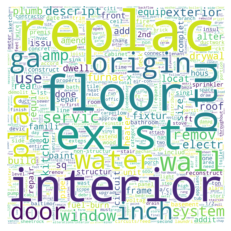

In [20]:
description_list_final = house_permit_from_file_filter['remove_common_word'].tolist()
word_list_final = []
for sublist in description_list_final:
    for word in sublist:
        word_list_final.append(word)
word_frequency_dict_final = FreqDist(word_list_final)
wordcloud_description_final = WordCloud(max_words = 1000,
                              width = 2000,
                              height = 2000,
                              background_color = 'white'
                             ).generate_from_frequencies(frequencies = word_frequency_dict_final)
plt.figure()
plt.imshow(wordcloud_description_final, interpolation='bilinear')
plt.axis('off')
wordcloud_description_final.to_file('house_permit_final.png')

In [37]:
description_list_updated = house_permit_from_file_filter['no_symbols'].tolist()
word_list = []
for sublist in description_list_updated:
    for word in sublist:
        word_list.append(word)

In [38]:
word_frequency_dict = FreqDist(word_list)
df_word_frequency = pd.DataFrame(word_frequency_dict.items(),columns=['word','frequency'])

In [39]:
df_word_frequency = df_word_frequency.sort_values(by = 'frequency', ascending = False).reset_index()

In [41]:
# del df_word_frequency['index']
df_word_frequency.head(50)

,word,frequency
0,per,543178
1,code,433649
2,instal,355066
3,new,266004
4,permit,260004
5,work,227685
6,replac,201182
7,floor,147899
8,interior,147358
9,exist,132929


(-0.5, 1999.5, 1999.5, -0.5)

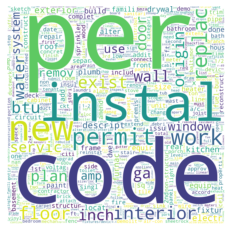

In [42]:
wordcloud_description_updated = WordCloud(max_words = 1000,
                              width = 2000,
                              height = 2000,
                              background_color = 'white'
                             ).generate_from_frequencies(frequencies = word_frequency_dict)
plt.figure()
plt.imshow(wordcloud_description_updated, interpolation='bilinear')
plt.axis('off')

In [43]:
wordcloud_description_updated.to_file('house_permit.png')